In [1]:
# Add path
import os
import sys
project_root = os.path.dirname(os.path.abspath(''))
sys.path.insert(0, project_root)
sys.path.insert(0, os.path.join(project_root, 'model'))
sys.path.insert(0, os.path.join(project_root, 'dataset_generation'))

In [2]:
# Reload modules
from importlib import reload
import util
import model
import value_decoder
import decoder
import encoder
reload(util)
reload(model)
reload(value_decoder)
reload(decoder)
reload(encoder)
from value_decoder import ValueDecoder
from decoder import Decoder
from encoder import Encoder

In [3]:
from copy import deepcopy
import torch
import numpy as np
import sympy as sp
from util import prods_to_eq, logits_to_prefix, logits_to_prods
from config_util import dict_to_config, load_config
from data_util import data2input, load_dataset, calc_priors_and_means, create_dataloader
from debug_util import plot_onehot
import wandb
from model import GrammarVAE
import yaml
from matplotlib import pyplot as plt
torch.manual_seed(41)

# Load dataset
datapath = '/Users/luis/Desktop/Cranmer 2024/Workplace/smallMutations/similar-expressions/data'
syntax, consts, val_x, val, syntax_cats = load_dataset(datapath=datapath, name='dataset_240822_1')
data_syntax = np.concatenate([syntax, consts[:, :, np.newaxis]], axis=-1)
value_transform = lambda x: torch.arcsinh(x)*0.1
val_transformed = value_transform(torch.tensor(val)).detach().numpy()

# Load model
run = '24ryl3yz'  # 'koxmwjg7'
wandb_cache_path = f'/Users/luis/Desktop/Cranmer 2024/Workplace/smallMutations/similar-expressions/wandb_cache'
with wandb.restore('model.pth', run_path=f"luis-carretero-eth-zurich/similar-expressions-01/runs/{run}", root=wandb_cache_path, replace=True) as io:
    name = io.name
checkpoint = torch.load(name, map_location='cpu')

# Read the model parameters from the WandB config.yaml file
with wandb.restore('config.yaml', run_path=f"luis-carretero-eth-zurich/similar-expressions-01/runs/{run}", root=wandb_cache_path, replace=True) as config_file:
    config = yaml.safe_load(config_file)
    cfg = {k: v['value'] for k, v in list(config.items()) if k not in ['wandb_version', '_wandb']}
    cfg = dict_to_config(cfg)

cfg.training.device = 'cpu'
vae_model = GrammarVAE(cfg)
vae_model.load_state_dict(checkpoint['model_state_dict'])

/var/folders/kn/k8zt16ss511gp4m6y14ttn840000gn/T/ipykernel_13204/3965906784.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(name, map_location='

Using updated value decoder 2.0!


<All keys matched successfully>

### Examine std of encoder

In [51]:
datapath = '/Users/luis/Desktop/Cranmer 2024/Workplace/smallMutations/similar-expressions/data'
train_loader, test_loader, hashes = create_dataloader(datapath, 'dataset_240817_2', cfg, value_transform=lambda x: torch.arcsinh(x)*0.1)
assert all([config['dataset_hashes']['value'][key] == hashes[key] for key in config['dataset_hashes']['value']]), "Error: Using different dataset than used for training."

## Raw latent space

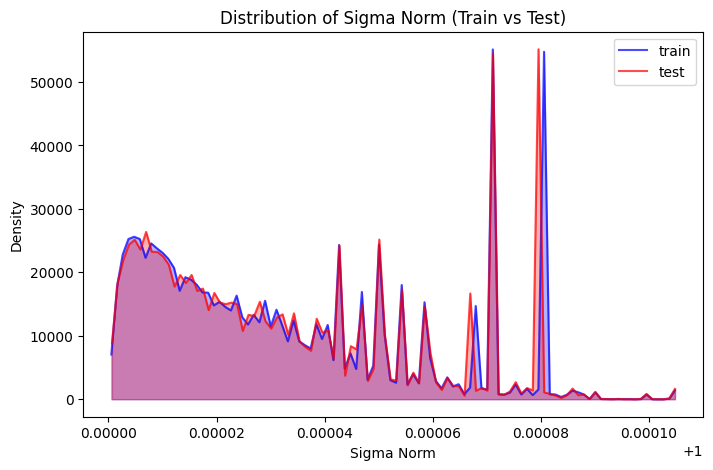

In [10]:
BATCH_SIZE = 2**15

cfg2 = deepcopy(cfg)
cfg2.training.batch_size = BATCH_SIZE
datapath = '/Users/luis/Desktop/Cranmer 2024/Workplace/smallMutations/similar-expressions/data'
train_loader, test_loader, hashes = create_dataloader(datapath, 'dataset_240822_1', cfg2, value_transform=lambda x: torch.arcsinh(x)*0.1, shuffle_train=False)
assert all([config['dataset_hashes']['value'][key] == hashes[key] for key in config['dataset_hashes']['value']]), "Error: Using different dataset than used for training."


sigma_norm_train = np.empty(len(train_loader.dataset))
mu_train = np.empty([len(train_loader.dataset), cfg.model.z_size])
z_train = np.empty([len(train_loader.dataset), cfg.model.z_size])
for i, (x, _, _, _) in enumerate(train_loader):
    # x = torch.tensor(data_syntax[:(2**15), ...].transpose(0, 2, 1))
    mean, ln_var = vae_model.encoder(x)
    z = vae_model.sample(mean, ln_var)
    res = ln_var.norm(dim=1).exp().detach().numpy()
    sigma_norm_train[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = res
    mu_train[i*BATCH_SIZE:(i+1)*BATCH_SIZE, :] = mean.detach().numpy()
    z_train[i*BATCH_SIZE:(i+1)*BATCH_SIZE, :] = z.detach().numpy()

sigma_norm_test = np.empty(len(test_loader.dataset))
mu_test = np.empty([len(test_loader.dataset), cfg.model.z_size])
z_test = np.empty([len(test_loader.dataset), cfg.model.z_size])
for i, (x, _, _, _) in enumerate(test_loader):
    # x = torch.tensor(data_syntax[:(2**15), ...].transpose(0, 2, 1))
    mean, ln_var = vae_model.encoder(x)
    z = vae_model.sample(mean, ln_var)
    res = ln_var.norm(dim=1).exp().detach().numpy()
    sigma_norm_test[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = res
    mu_test[i*BATCH_SIZE:(i+1)*BATCH_SIZE, :] = mean.detach().numpy()
    z_test[i*BATCH_SIZE:(i+1)*BATCH_SIZE, :] = z.detach().numpy()

# Calculate the histogram data without plotting
train_hist, train_bins = np.histogram(sigma_norm_train, bins=100, density=True)
test_hist, test_bins = np.histogram(sigma_norm_test, bins=100, density=True)

# Calculate bin centers for plotting
train_bin_centers = (train_bins[:-1] + train_bins[1:]) / 2
test_bin_centers = (test_bins[:-1] + test_bins[1:]) / 2

# Create a plot for direct comparison
plt.figure(figsize=(8, 5))
plt.plot(train_bin_centers, train_hist, label='train', color='blue', alpha=0.7)
plt.plot(test_bin_centers, test_hist, label='test', color='red', alpha=0.7)
plt.fill_between(train_bin_centers, train_hist, alpha=0.3, color='blue')
plt.fill_between(test_bin_centers, test_hist, alpha=0.3, color='red')
plt.xlabel('Sigma Norm')
plt.ylabel('Density')
plt.title('Distribution of Sigma Norm (Train vs Test)')
plt.legend()
plt.show()

In [26]:
0.05 * 192

9.600000000000001

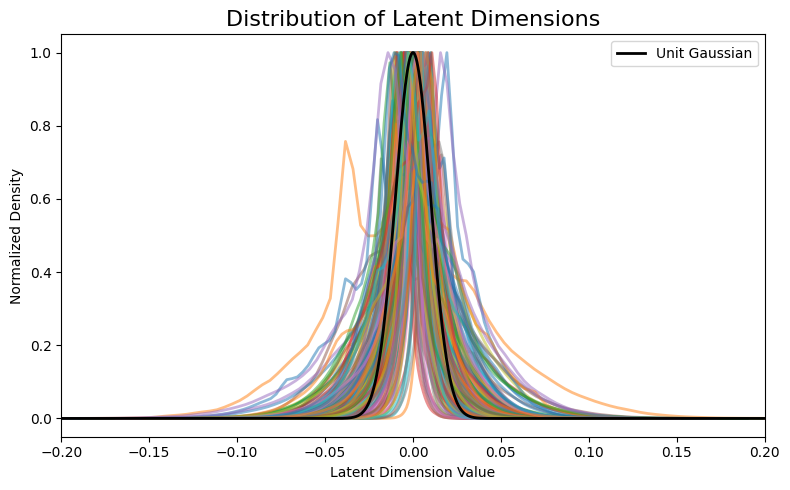

In [22]:
import numpy as np
from scipy.stats import norm
from scipy.ndimage import gaussian_filter1d

# Calculate the histogram data for the first 192 dimensions
num_dims = cfg.model.z_size
num_bins = 100
hist_data = []
bin_edges = []

for dim in range(num_dims):
    hist, bins = np.histogram(mu_train[:, dim], bins=num_bins, density=True)
    hist = gaussian_filter1d(hist, sigma=1)
    hist_data.append(hist)
    bin_edges.append(bins)

# Calculate bin centers
bin_centers = [(bins[:-1] + bins[1:]) / 2 for bins in bin_edges]

# Normalize histograms to the same height
normalized_hist_data = [hist / np.max(hist) for hist in hist_data]

# Create a single plot for all 192 dimensions
plt.figure(figsize=(8, 5))
plt.title('Distribution of Latent Dimensions', fontsize=16)

# Plot each dimension
for dim in range(num_dims):
    plt.plot(bin_centers[dim], normalized_hist_data[dim], linewidth=2, alpha=0.5)

# Add unit Gaussian (mu=0, sigma=1)
x = np.linspace(-1, 1, 10000)
gaussian = norm.pdf(x, 0, 0.01)
normalized_gaussian = gaussian / np.max(gaussian)
plt.plot(x, normalized_gaussian, 'k', linewidth=2, label='Unit Gaussian')

plt.xlim(np.array([-1, 1])*0.2)
plt.xlabel('Latent Dimension Value')
plt.ylabel('Normalized Density')
plt.legend()
plt.tight_layout()

### Examine neighbourhood in latent space of training samples 

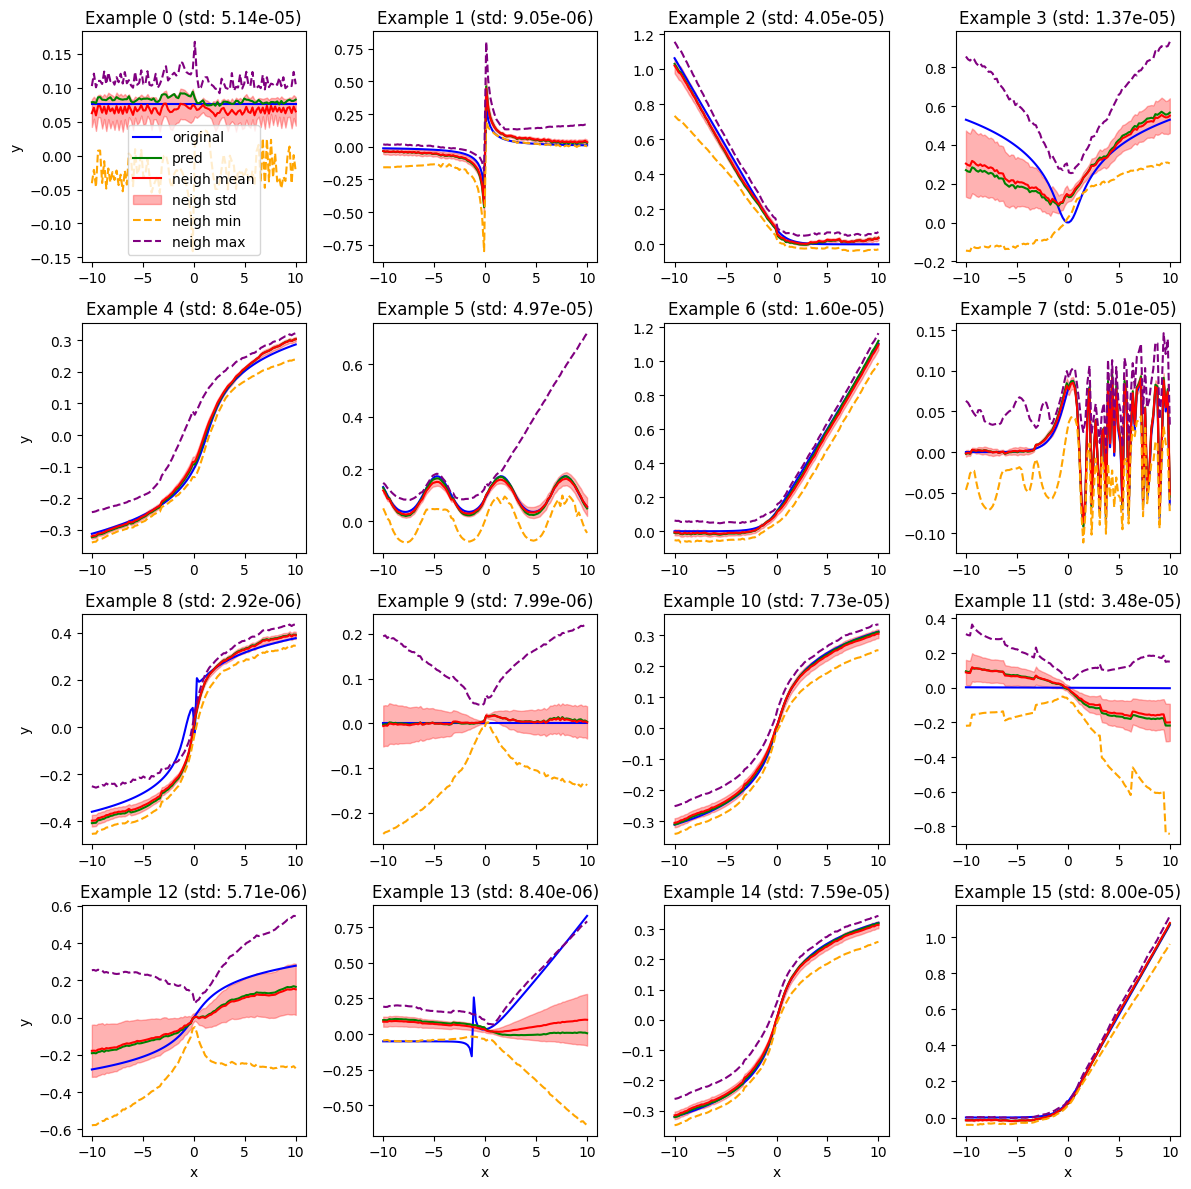

In [21]:
i = 0
N = 16
data_loader = test_loader

# Encode into latent space
x = data_loader.dataset.dataset[data_loader.dataset.indices][0][i:i+N, ...]
val_transformed = data_loader.dataset.dataset[data_loader.dataset.indices][3][i:i+N, ...]
mean, ln_var = vae_model.encoder(x)
values = vae_model.value_decoder(mean)

# Sample from neighbourhood in latent space
samples = []
for _ in range(1000):  # Number of samples
    z = vae_model.sample(mean, ln_var)  # Sample from neighbourhood in latent space
    values_neigh = vae_model.value_decoder(z)
    samples.append(values_neigh.squeeze().detach().numpy())
samples = np.array(samples).transpose(1, 0, 2)
mean_samples = np.mean(samples, axis=1)
std_samples = np.std(samples, axis=1)
min_samples = np.min(samples, axis=1)
max_samples = np.max(samples, axis=1)

# Plot
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
axes = axes.flatten()
for idx in range(N):
    ax = axes[idx]
    ax.plot(val_x.squeeze(), val_transformed[idx, :].squeeze(), label='original', color='blue')
    ax.plot(val_x.squeeze(), values[idx].squeeze().detach().numpy(), label='pred', color='green')
    ax.plot(val_x.squeeze(), mean_samples[idx], label='neigh mean', color='red')
    ax.fill_between(val_x.squeeze(), 
                    mean_samples[idx] - std_samples[idx], 
                    mean_samples[idx] + std_samples[idx], 
                    alpha=0.3, color='red', label='neigh std')
    ax.plot(val_x.squeeze(), min_samples[idx], label='neigh min', color='orange', linestyle='--')
    ax.plot(val_x.squeeze(), max_samples[idx], label='neigh max', color='purple', linestyle='--')
    
    if idx % 4 == 0:  # Only add y-label to the leftmost subplots
        ax.set_ylabel('y')
    if idx >= 12:  # Only add x-label to the bottom subplots
        ax.set_xlabel('x')
    ax.set_title(f'Example {idx} (std: {ln_var[idx].norm().item():.2e})')
    
    if idx == 0:  # Only add legend to the first subplot
        ax.legend()

plt.tight_layout()
plt.show()

In [32]:
import torch.nn.functional as F

i = 0
N = 16
data_loader = train_loader
x = data_loader.dataset.dataset[data_loader.dataset.indices][0][i:i+N, ...]

# Encode into latent space
mean, ln_var = vae_model.encoder(x)
logits = vae_model.decoder(mean, max_length=15)
values = vae_model.value_decoder(mean)

# Sample from neighbourhood in latent space
samples = []
for _ in range(1000):  # Number of samples
    z = vae_model.sample(mean, ln_var)  # Sample from neighbourhood in latent space
    logits = vae_model.decoder(z, max_length=15)
    samples.append(logits.squeeze().detach().numpy())
samples = np.array(samples).transpose(1, 0, 2, 3)
syntax_samples = samples[:, :, :, :-1]
syntax_samples = F.softmax(torch.tensor(syntax_samples), dim=-1).numpy()
consts_samples = samples[:, :, :, -1]

mean_samples = np.mean(syntax_samples, axis=1)
std_samples = np.std(syntax_samples, axis=1)
min_samples = np.min(syntax_samples, axis=1)
max_samples = np.max(syntax_samples, axis=1)

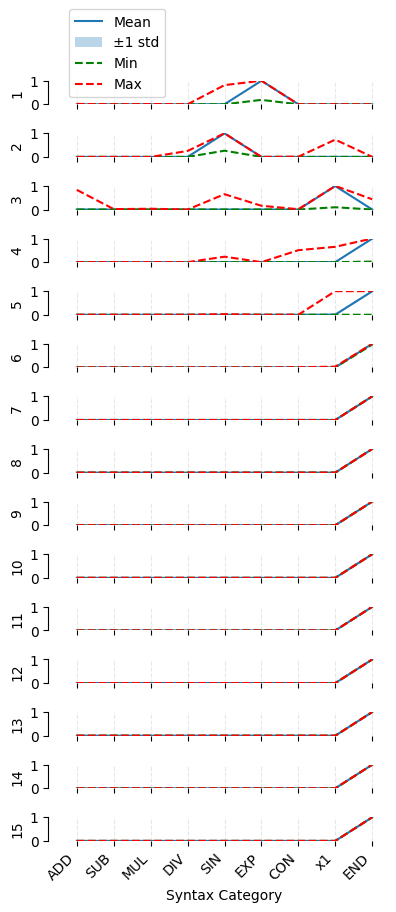

In [33]:
n = 0

fig, axes = plt.subplots(mean_samples.shape[1], 1, figsize=(4, 0.6*mean_samples.shape[1]), sharex=True)
plt.subplots_adjust(hspace=0)  # Remove vertical space between subplots
for i in range(mean_samples.shape[1]):
    axes[i].plot(mean_samples[n, i, :], label='Mean')
    axes[i].fill_between(range(mean_samples.shape[2]),
                         mean_samples[n, i, :] - std_samples[n, i, :],
                         mean_samples[n, i, :] + std_samples[n, i, :],
                         alpha=0.3, label='±1 std')
    axes[i].plot(min_samples[n, i, :], label='Min', linestyle='--', color='green')
    axes[i].plot(max_samples[n, i, :], label='Max', linestyle='--', color='red')
    axes[i].set_xticks(range(len(syntax_cats)))
    axes[i].set_xticklabels(syntax_cats, rotation=45, ha='right')
    axes[i].grid(True, axis='x', linestyle='--', alpha=0.3)
    axes[i].set_ylim(0, 1)  # Set y-limit between 0 and 1
    axes[i].set_ylabel(f'{i+1}')  # Add y-label showing timestep
    if i == mean_samples.shape[1] - 1:
        axes[i].set_xlabel('Syntax Category')
    if i == 0:
        axes[i].legend()
    axes[i].spines['top'].set_visible(False)  # Remove top border
    axes[i].spines['bottom'].set_visible(False)  # Remove bottom border
    axes[i].spines['right'].set_visible(False)  # Remove right border
    axes[i].spines['left'].set_position(('outward', 10))  # Move left spine outward

plt.tight_layout()
plt.subplots_adjust(right=0.98)  # Reduce right margin
plt.show()

## Mean distance

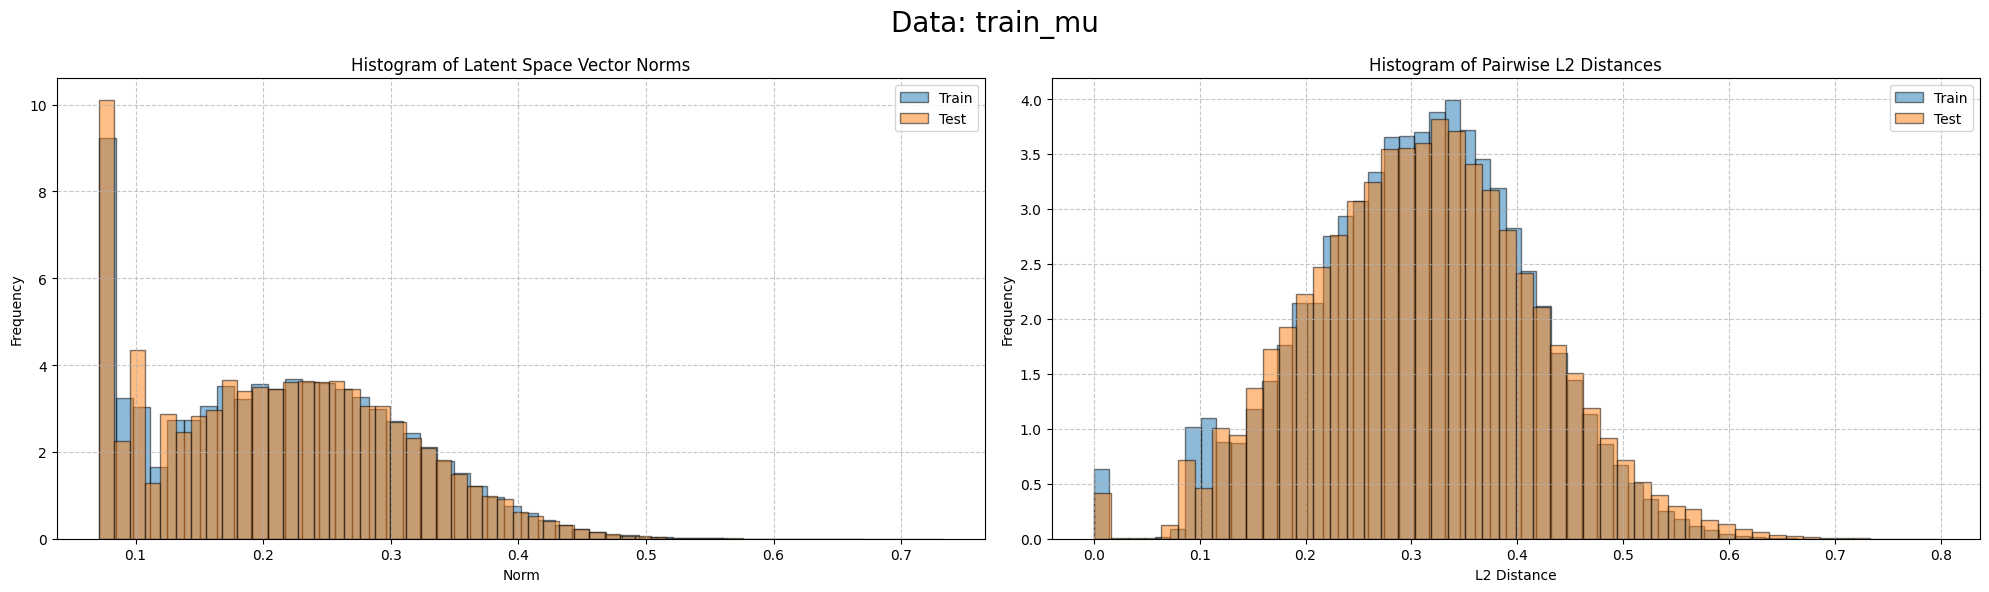

In [31]:
# Calculate for mu_train
datatype = 'train'
data = {
    'mu': (mu_train, mu_test),
    'z': (z_train, z_test)
}
z_data = data[datatype][0]
mu_train_norms = np.linalg.norm(z_data, axis=1)

sample_size = 1000
sampled_mu_train = z_data[np.random.choice(z_data.shape[0], sample_size, replace=False)]
pairwise_distances_train = np.linalg.norm(sampled_mu_train[:, np.newaxis] - sampled_mu_train, axis=2)
l2_distances_train = pairwise_distances_train[np.triu_indices(sample_size, k=1)]

# Calculate for mu_test
z_data = data[datatype][1]
mu_test_norms = np.linalg.norm(z_data, axis=1)
sampled_mu_test = z_data[np.random.choice(z_data.shape[0], sample_size, replace=False)]
pairwise_distances_test = np.linalg.norm(sampled_mu_test[:, np.newaxis] - sampled_mu_test, axis=2)
l2_distances_test = pairwise_distances_test[np.triu_indices(sample_size, k=1)]

# Plot histograms
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Plot histogram of norms
ax1.hist(mu_train_norms, bins=50, alpha=0.5, label='Train', edgecolor='black', density=True)
ax1.hist(mu_test_norms, bins=50, alpha=0.5, label='Test', edgecolor='black', density=True)
ax1.set_title('Histogram of Latent Space Vector Norms')
ax1.set_xlabel('Norm')
ax1.set_ylabel('Frequency')
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.legend()

# Plot histogram of L2 distances
ax2.hist(l2_distances_train, bins=50, alpha=0.5, label='Train', edgecolor='black', density=True)
ax2.hist(l2_distances_test, bins=50, alpha=0.5, label='Test', edgecolor='black', density=True)
ax2.set_title('Histogram of Pairwise L2 Distances')
ax2.set_xlabel('L2 Distance')
ax2.set_ylabel('Frequency')
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.legend()
fig.suptitle(f'Data: {datatype}', fontsize=20)

plt.tight_layout()
plt.show()


## Interpolation study

Distance: 0.1559564566017766


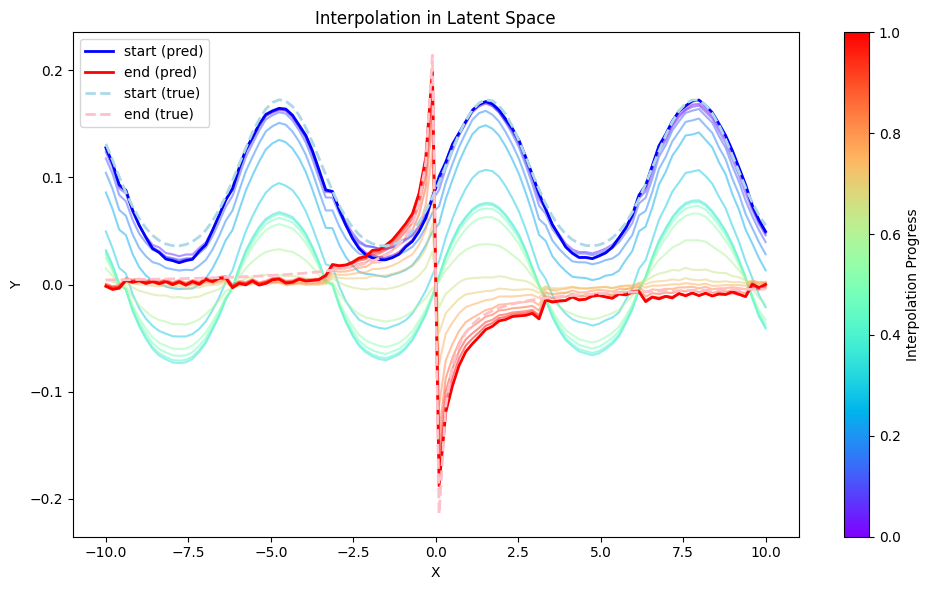

In [19]:
# Next: Choose a specific distance.
i, j = 0, 2
alpha = np.linspace(1, 0, 20)

print(f'Distance: {np.linalg.norm(mu_train[i] - mu_train[j])}')
mu_interp = alpha[:, np.newaxis] * mu_train[i] + (1 - alpha[:, np.newaxis]) * mu_train[j]
values_interp = vae_model.value_decoder(torch.tensor(mu_interp.astype(np.float32)))

# Create a colormap for smooth color transition
cmap = plt.get_cmap('rainbow')

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot interpolated values with smooth color change
for idx, value in enumerate(values_interp[1:-1]):
    color = cmap(idx / (len(values_interp) - 3))
    ax.plot(val_x.squeeze(), value.detach().numpy(), color=color, alpha=0.5)

# Plot start and end points
ax.plot(val_x.squeeze(), values_interp[0].squeeze().detach().numpy(), label='start (pred)', color='blue', linewidth=2)
ax.plot(val_x.squeeze(), values_interp[-1].squeeze().detach().numpy(), label='end (pred)', color='red', linewidth=2)

ax.plot(val_x.squeeze(), train_loader.dataset.dataset[train_loader.dataset.indices][3][i, ...].squeeze().detach().numpy(), label='start (true)', color='lightblue', linewidth=2, linestyle='--')
ax.plot(val_x.squeeze(), train_loader.dataset.dataset[train_loader.dataset.indices][3][j, ...].squeeze().detach().numpy(), label='end (true)', color='pink', linewidth=2, linestyle='--')


# Add a colorbar to show the interpolation progression
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Interpolation Progress')

ax.legend()
ax.set_title('Interpolation in Latent Space')
ax.set_xlabel('X')
ax.set_ylabel('Y')

plt.tight_layout()
plt.show()

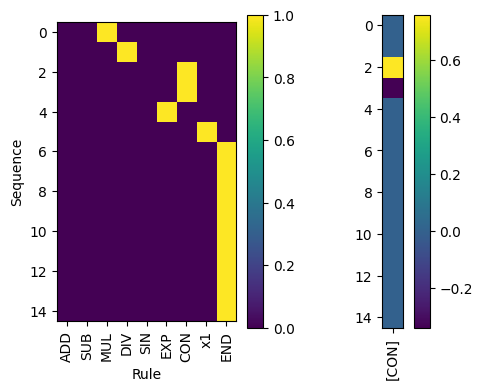

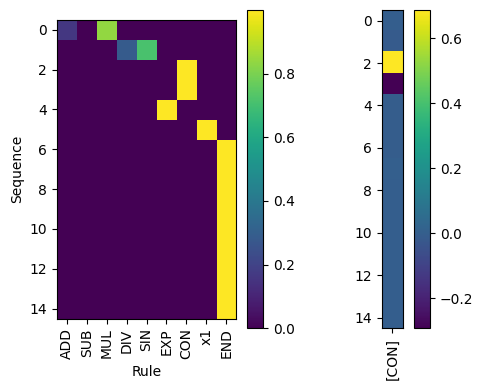

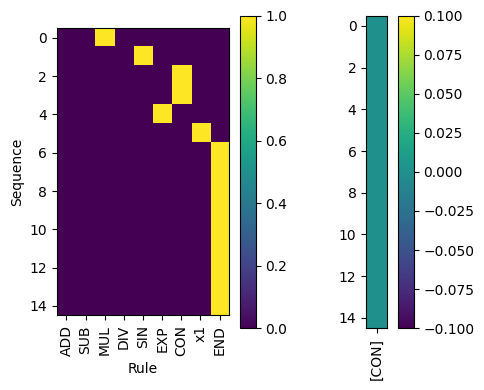

In [75]:
x = train_loader.dataset.dataset[train_loader.dataset.indices][0][0, ...].unsqueeze(0)

logits, values = vae_model(x)

plot_onehot(x.squeeze(0).T.detach().numpy(), syntax_cats, figsize=(5, 4))
plot_onehot(logits.squeeze(0).detach().numpy(), syntax_cats, apply_softmax=True, figsize=(5, 4))
# Convert logits to one-hot encoding
logits_np = logits.squeeze(0).detach().numpy()
one_hot = np.zeros_like(logits_np)
one_hot[np.arange(len(logits_np)), logits_np.argmax(axis=1)] = 1
plot_onehot(one_hot, syntax_cats, figsize=(5, 4))


## Raw latent space